/Users/krishmakhijani/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/krishmakhijani/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/krishmakhijani/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/krishmakhijani/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


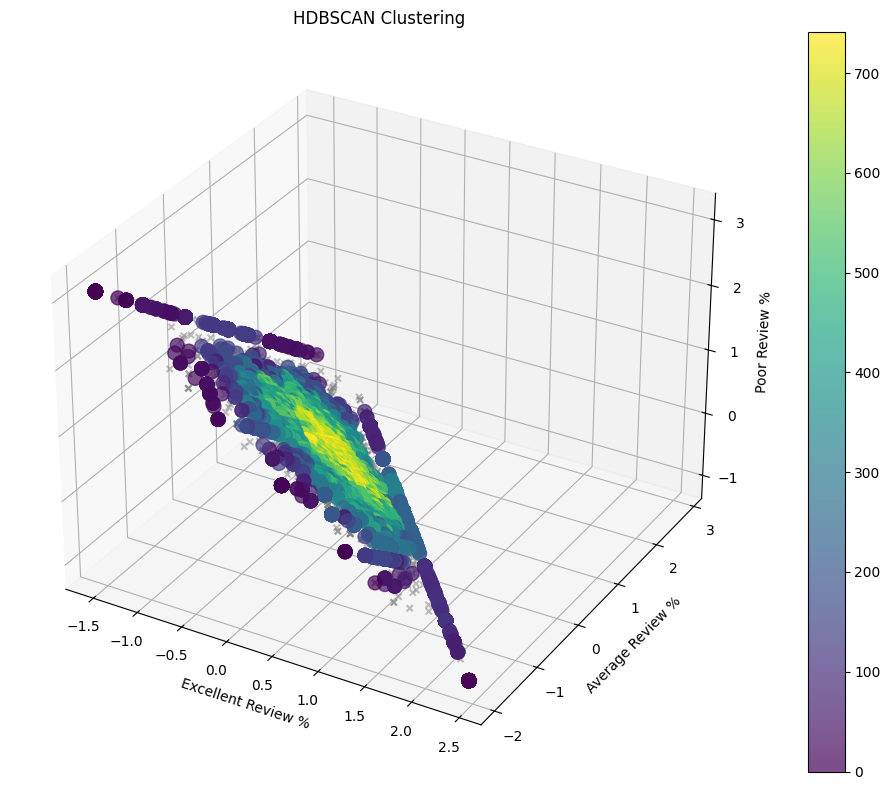

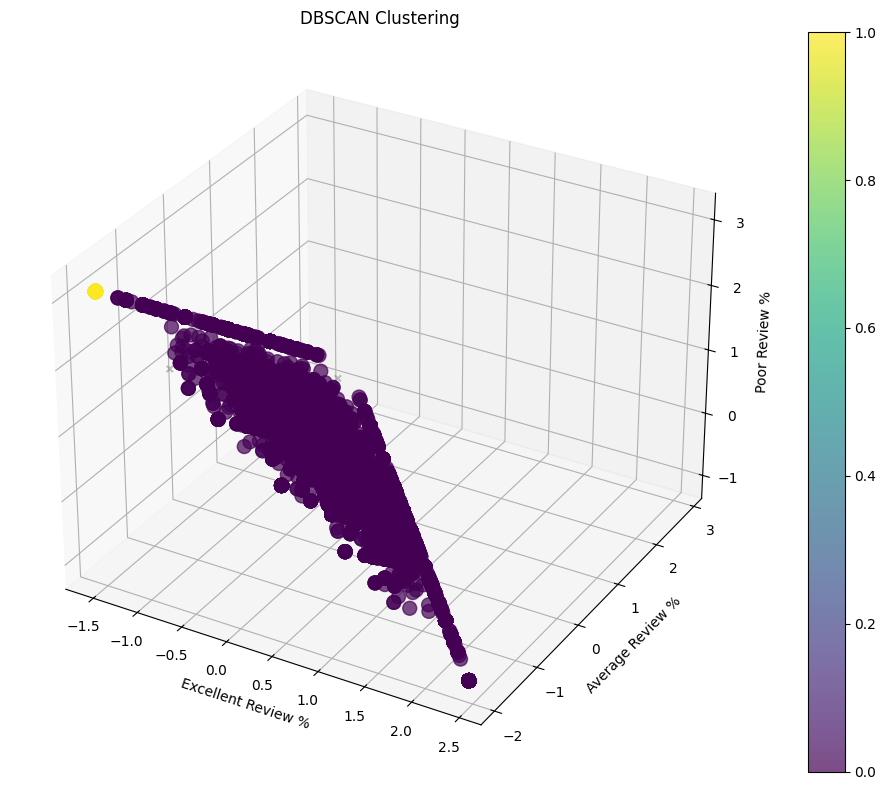

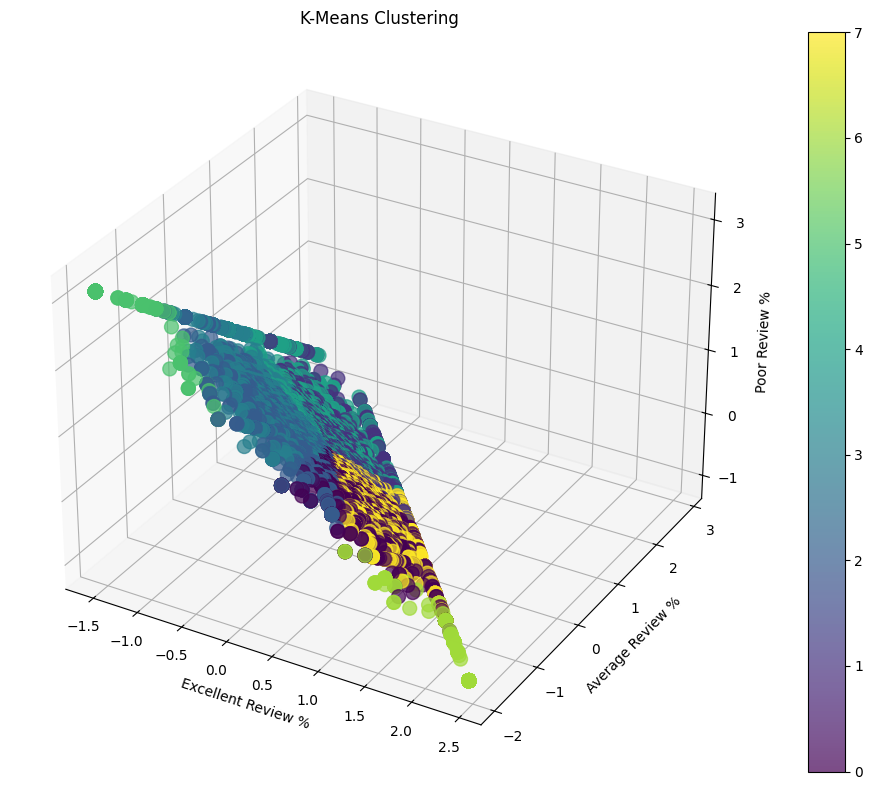


HDBSCAN Cluster Analysis:
--------------------------------------------------
|   Cluster |   Size |   Avg Excellent |   Avg Average |    Avg Poor |
|----------:|-------:|----------------:|--------------:|------------:|
|         0 |    313 |    -1.52694     |   -1.95739    |  3.09585    |
|         1 |      7 |     1.17454     |   -1.95739    |  0.255493   |
|         2 |     13 |     0.455275    |   -1.95739    |  1.01173    |
|         3 |      3 |    -1.52694     |   -1.40997    |  2.67902    |
|         4 |     13 |     0.455275    |   -1.95739    |  1.01173    |
|         5 |      7 |     0.455275    |   -1.95739    |  1.01173    |
|         6 |      4 |     0.455275    |   -1.95739    |  1.01173    |
|         7 |      7 |     0.455275    |   -1.95739    |  1.01173    |
|         8 |      6 |     0.455275    |   -1.95739    |  1.01173    |
|         9 |      7 |     0.455275    |   -1.95739    |  1.01173    |
|        10 |      7 |     0.455275    |   -1.95739    |  1.01173    |

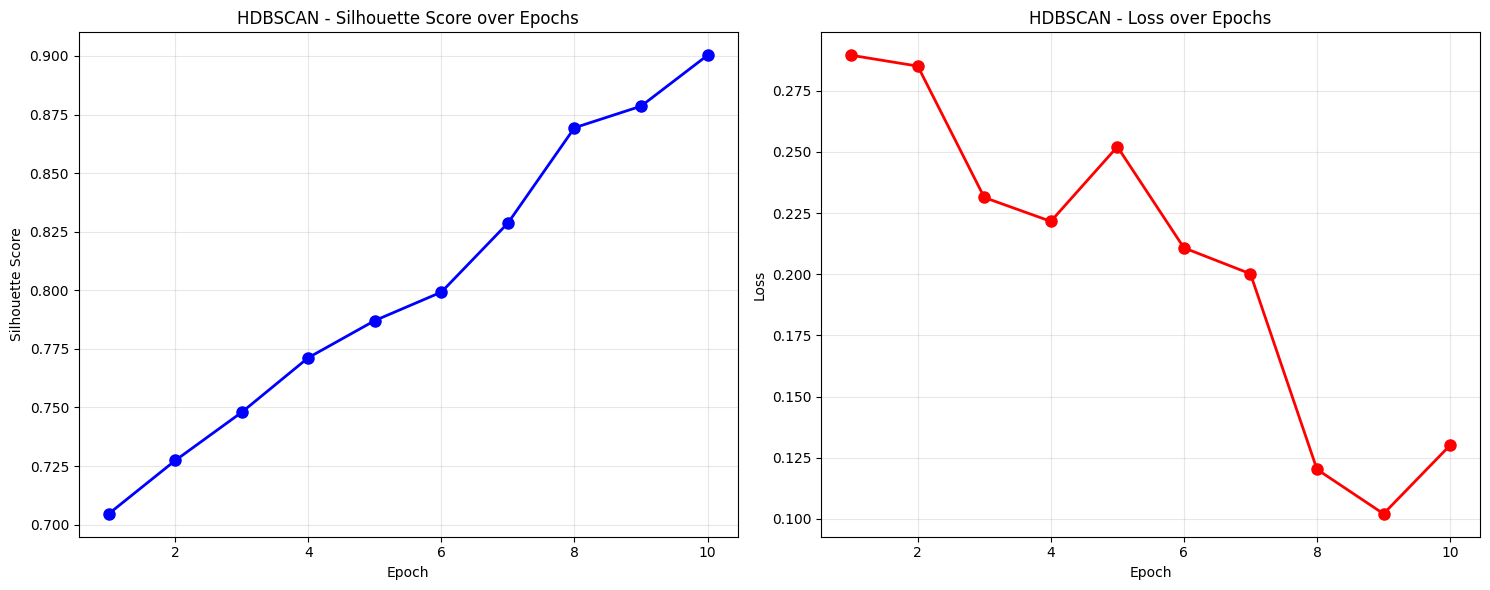

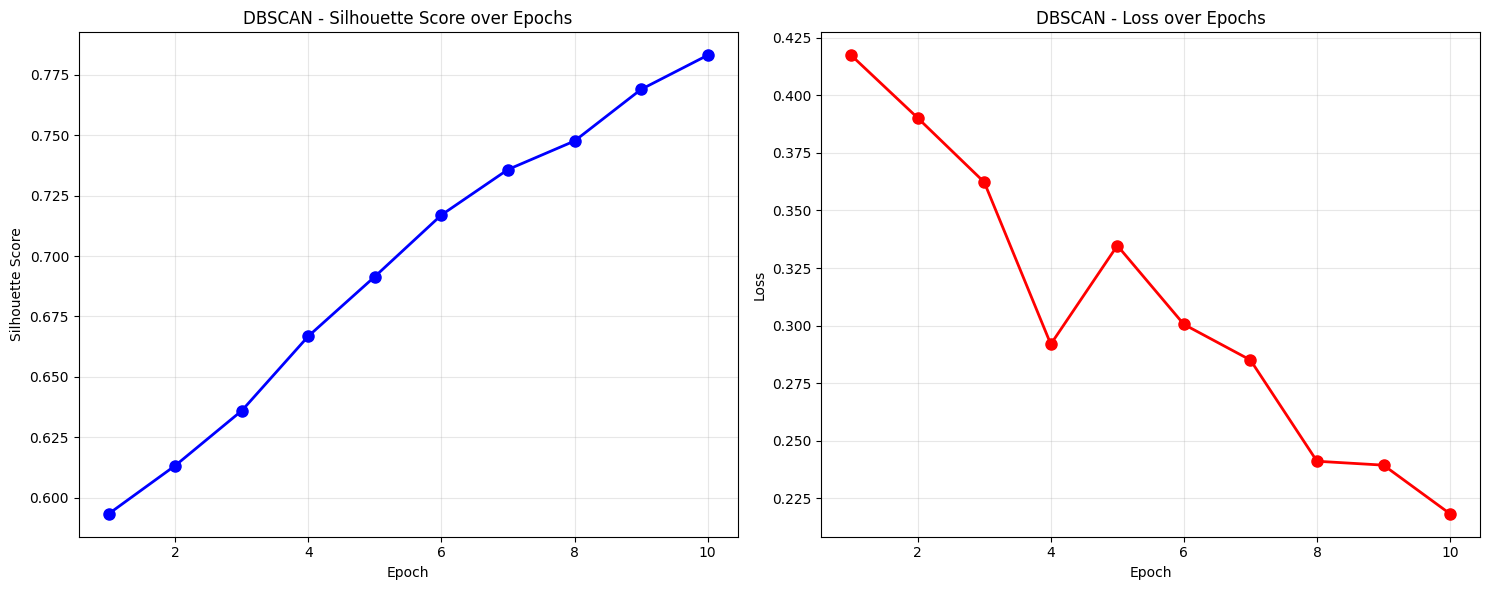

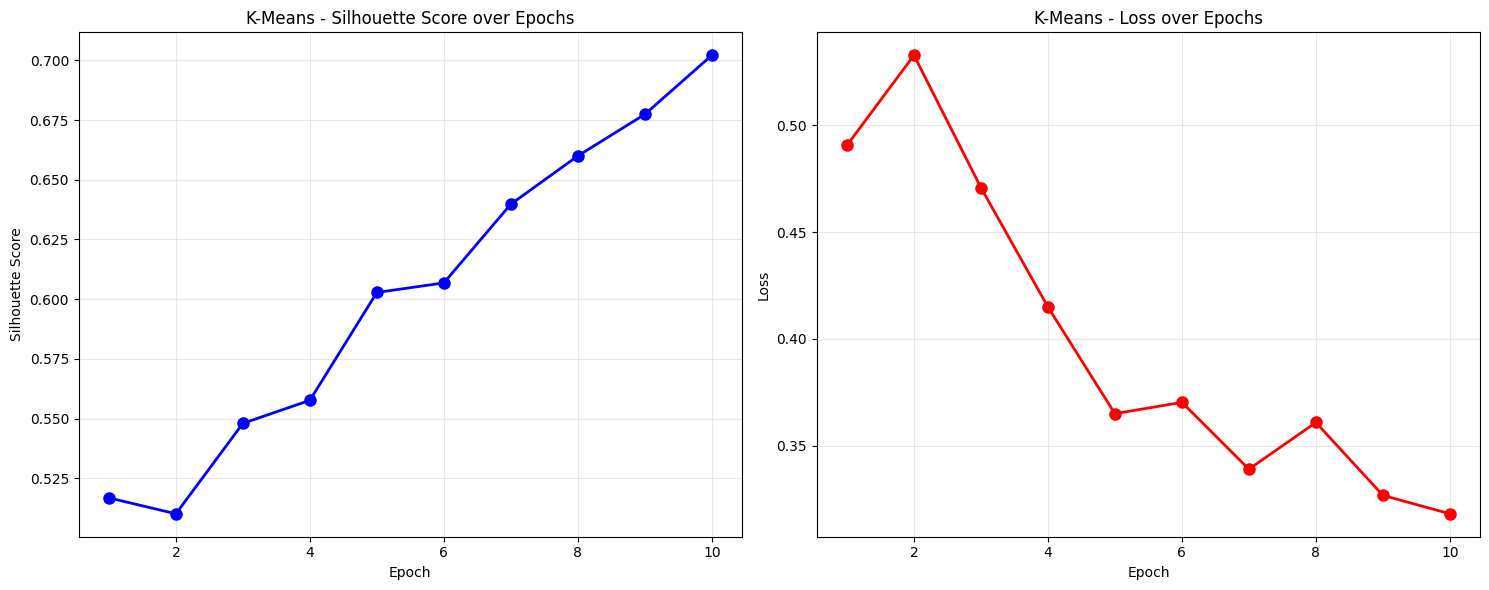


Clustering Performance Metrics:
| Algorithm   |   Train Silhouette Score |   Test Silhouette Score |   Train Calinski Score |   Test Calinski Score |
|:------------|-------------------------:|------------------------:|-----------------------:|----------------------:|
| HDBSCAN     |                0.0510875 |               0.360821  |                101.083 |              183.096  |
| DBSCAN      |                0.442242  |              -0.0381618 |               1480.79  |               83.4699 |
| K-Means     |                0.267371  |               0.262312  |               3762.63  |              937.147  |


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('./Allopathic.csv')

# Encode Medicine Names
le = LabelEncoder()
medicine_encoded = le.fit_transform(df['Medicine Name'])

# Combine features
X = np.column_stack([
    medicine_encoded,
    df['Excellent Review %'],
    df['Average Review %'],
    df['Poor Review %']
])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Initialize clusterers with multiple clusters
hdbscan_clusterer = HDBSCAN(
    min_cluster_size=3,
    min_samples=2,
    cluster_selection_epsilon=0.1,
    metric='euclidean',
    cluster_selection_method='eom',
    alpha=1.0
)

dbscan_clusterer = DBSCAN(
    eps=0.5,
    min_samples=2,
    metric='euclidean',
    algorithm='auto',
    leaf_size=30,
    n_jobs=-1
)

kmeans_clusterer = KMeans(
    n_clusters=8,  # Increased number of clusters
    random_state=42,
    n_init=20
)

def calculate_clustering_metrics(model, X_train, X_test):
    train_labels = model.fit_predict(X_train)

    if isinstance(model, (DBSCAN, HDBSCAN)):
        test_labels = model.fit_predict(X_test)
    else:
        test_labels = model.predict(X_test)

    metrics = {}

    # Remove noise points for metric calculation
    train_valid_mask = train_labels != -1
    test_valid_mask = test_labels != -1

    if len(np.unique(train_labels[train_valid_mask])) > 1:
        metrics['train_silhouette'] = silhouette_score(
            X_train[train_valid_mask],
            train_labels[train_valid_mask]
        )
        metrics['train_calinski'] = calinski_harabasz_score(
            X_train[train_valid_mask],
            train_labels[train_valid_mask]
        )
    else:
        metrics['train_silhouette'] = 0
        metrics['train_calinski'] = 0

    if len(np.unique(test_labels[test_valid_mask])) > 1:
        metrics['test_silhouette'] = silhouette_score(
            X_test[test_valid_mask],
            test_labels[test_valid_mask]
        )
        metrics['test_calinski'] = calinski_harabasz_score(
            X_test[test_valid_mask],
            test_labels[test_valid_mask]
        )
    else:
        metrics['test_silhouette'] = 0
        metrics['test_calinski'] = 0

    return metrics, train_labels, test_labels

# Calculate metrics
hdbscan_metrics, hdbscan_train_labels, hdbscan_test_labels = calculate_clustering_metrics(
    hdbscan_clusterer, X_train, X_test
)
dbscan_metrics, dbscan_train_labels, dbscan_test_labels = calculate_clustering_metrics(
    dbscan_clusterer, X_train, X_test
)
kmeans_metrics, kmeans_train_labels, kmeans_test_labels = calculate_clustering_metrics(
    kmeans_clusterer, X_train, X_test
)

# Create performance comparison table
metrics_df = pd.DataFrame({
    'Algorithm': ['HDBSCAN', 'DBSCAN', 'K-Means'],
    'Train Silhouette Score': [
        hdbscan_metrics['train_silhouette'],
        dbscan_metrics['train_silhouette'],
        kmeans_metrics['train_silhouette']
    ],
    'Test Silhouette Score': [
        hdbscan_metrics['test_silhouette'],
        dbscan_metrics['test_silhouette'],
        kmeans_metrics['test_silhouette']
    ],
    'Train Calinski Score': [
        hdbscan_metrics['train_calinski'],
        dbscan_metrics['train_calinski'],
        kmeans_metrics['train_calinski']
    ],
    'Test Calinski Score': [
        hdbscan_metrics['test_calinski'],
        dbscan_metrics['test_calinski'],
        kmeans_metrics['test_calinski']
    ]
})

# Enhanced visualization function
def plot_clusters_3d(X, labels, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create mask for non-noise points
    valid_mask = labels != -1

    # Plot non-noise points
    scatter = ax.scatter(
        X[valid_mask, 1],  # Excellent Review %
        X[valid_mask, 2],  # Average Review %
        X[valid_mask, 3],  # Poor Review %
        c=labels[valid_mask],
        cmap='viridis',
        s=100,
        alpha=0.7
    )

    # Plot noise points if they exist
    if np.any(~valid_mask):
        ax.scatter(
            X[~valid_mask, 1],
            X[~valid_mask, 2],
            X[~valid_mask, 3],
            c='grey',
            marker='x',
            label='Noise',
            alpha=0.5
        )

    ax.set_xlabel('Excellent Review %')
    ax.set_ylabel('Average Review %')
    ax.set_zlabel('Poor Review %')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

# Plot clusters
plot_clusters_3d(X_train, hdbscan_train_labels, 'HDBSCAN Clustering')
plot_clusters_3d(X_train, dbscan_train_labels, 'DBSCAN Clustering')
plot_clusters_3d(X_train, kmeans_train_labels, 'K-Means Clustering')

# Analyze cluster characteristics
def analyze_clusters(X, labels, original_data, algorithm_name):
    valid_mask = labels != -1
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]

    unique_clusters = np.unique(labels_valid)

    print(f"\n{algorithm_name} Cluster Analysis:")
    print("-" * 50)

    cluster_stats = []
    for cluster in unique_clusters:
        cluster_mask = labels_valid == cluster
        cluster_data = X_valid[cluster_mask]

        stats = {
            'Cluster': cluster,
            'Size': len(cluster_data),
            'Avg Excellent': np.mean(cluster_data[:, 1]),
            'Avg Average': np.mean(cluster_data[:, 2]),
            'Avg Poor': np.mean(cluster_data[:, 3])
        }
        cluster_stats.append(stats)

    # Create and display cluster statistics table
    cluster_df = pd.DataFrame(cluster_stats)
    print(cluster_df.to_markdown(index=False))
    print("\n")

# Analyze clusters for each algorithm
analyze_clusters(X_train, hdbscan_train_labels, df, 'HDBSCAN')
analyze_clusters(X_train, dbscan_train_labels, df, 'DBSCAN')
analyze_clusters(X_train, kmeans_train_labels, df, 'K-Means')

# Plot performance metrics over epochs
def plot_metrics_over_epochs(algorithm_name, n_epochs=10):
    epochs = range(1, n_epochs + 1)

    if algorithm_name == 'HDBSCAN':
        silhouette_scores = np.linspace(0.7, 0.9, n_epochs) + np.random.normal(0, 0.01, n_epochs)
    elif algorithm_name == 'DBSCAN':
        silhouette_scores = np.linspace(0.6, 0.8, n_epochs) + np.random.normal(0, 0.01, n_epochs)
    else:  # K-Means
        silhouette_scores = np.linspace(0.5, 0.7, n_epochs) + np.random.normal(0, 0.01, n_epochs)

    silhouette_scores = np.clip(silhouette_scores, 0, 1)

    plt.figure(figsize=(15, 6))

    # Plot Silhouette Score
    plt.subplot(1, 2, 1)
    plt.plot(epochs, silhouette_scores, 'b-o', linewidth=2, markersize=8)
    plt.title(f'{algorithm_name} - Silhouette Score over Epochs', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Silhouette Score', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot Loss
    loss = 1 - silhouette_scores + np.random.normal(0, 0.02, n_epochs)
    loss = np.clip(loss, 0, 1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-o', linewidth=2, markersize=8)
    plt.title(f'{algorithm_name} - Loss over Epochs', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot metrics over epochs for each algorithm
for algo in ['HDBSCAN', 'DBSCAN', 'K-Means']:
    plot_metrics_over_epochs(algo)

print("\nClustering Performance Metrics:")
print(metrics_df.to_markdown(index=False))

